In [1]:
import catboost as cb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
model = cb.CatBoostRegressor(cat_features=['region'])
model = model.load_model('model_depth_10_2')

In [3]:
df = pd.read_csv('earthquakes.csv')

df.time = pd.to_datetime(df.time)
df = df.loc[df.time >= "1974-01-01"]
df = df.sort_values("time")
df = df.set_index("time")

df["region"] = df.place.str.split(", ", expand=True)[1]
df.region = df.region.fillna(df.place)
df.region = df.region.replace("CA", "California")
df.region = df.region.replace("B.C.", "Baja California")

df = df[["depth", "mag", "region", "latitude", "longitude"]]

regions = df.region.value_counts()
top_k = 25
top_k_regions = regions.head(top_k).index

df = df.loc[df.region.isin(top_k_regions)]

df = df.groupby("region").resample("d").mean()
df = df.reset_index()
df.mag = df.mag.ffill()
df.depth = df.depth.ffill()
df.latitude = df.latitude.ffill()
df.longitude = df.longitude.ffill()

df["day"] = df.time.dt.day
df["month"] = df.time.dt.month
df["dayofweek"] = df.time.dt.dayofweek
df["dayofyear"] = df.time.dt.dayofyear

start_lag = 3
end_lag = 12
for i in range(start_lag, end_lag + 1):
    df[f"mag_lag_{i}"] = df.groupby("region").mag.shift(i)

df[f"mag_rolling_mean_{start_lag}"] = df.groupby("region").mag.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
df[f"mag_rolling_std_{start_lag}"] = df.groupby("region").mag.transform(
    lambda x: x.rolling(window=start_lag).std()
)
df[f"mag_rolling_mean_{end_lag}"] = df.groupby("region").mag.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
df[f"mag_rolling_std_{end_lag}"] = df.groupby("region").mag.transform(
    lambda x: x.rolling(window=end_lag).std()
)

df[f"depth_rolling_mean_{start_lag}"] = df.groupby("region").depth.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
df[f"depth_rolling_std_{start_lag}"] = df.groupby("region").depth.transform(
    lambda x: x.rolling(window=start_lag).std()
)
df[f"depth_rolling_mean_{end_lag}"] = df.groupby("region").depth.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
df[f"depth_rolling_std_{end_lag}"] = df.groupby("region").depth.transform(
    lambda x: x.rolling(window=end_lag).std()
)

df[f"latitude_rolling_mean_{start_lag}"] = df.groupby("region").latitude.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
df[f"latitude_rolling_std_{start_lag}"] = df.groupby("region").latitude.transform(
    lambda x: x.rolling(window=start_lag).std()
)
df[f"latitude_rolling_mean_{end_lag}"] = df.groupby("region").latitude.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
df[f"latitude_rolling_std_{end_lag}"] = df.groupby("region").latitude.transform(
    lambda x: x.rolling(window=end_lag).std()
)

df[f"longitude_rolling_mean_{start_lag}"] = df.groupby("region").longitude.transform(
    lambda x: x.rolling(window=start_lag).mean()
)
df[f"longitude_rolling_std_{start_lag}"] = df.groupby("region").longitude.transform(
    lambda x: x.rolling(window=start_lag).std()
)
df[f"longitude_rolling_mean_{end_lag}"] = df.groupby("region").longitude.transform(
    lambda x: x.rolling(window=end_lag).mean()
)
df[f"longitude_rolling_std_{end_lag}"] = df.groupby("region").longitude.transform(
    lambda x: x.rolling(window=end_lag).std()
)

In [4]:
features = [
    "day",
    "month",
    "dayofweek",
    "dayofyear",
    f"mag_rolling_mean_{start_lag}",
    f"mag_rolling_std_{start_lag}",
    f"depth_rolling_mean_{start_lag}",
    f"depth_rolling_std_{start_lag}",
    f"latitude_rolling_mean_{start_lag}",
    f"latitude_rolling_std_{start_lag}",
    f"longitude_rolling_mean_{start_lag}",
    f"longitude_rolling_std_{start_lag}",
    f"mag_rolling_mean_{end_lag}",
    f"mag_rolling_std_{end_lag}",
    f"depth_rolling_mean_{end_lag}",
    f"depth_rolling_std_{end_lag}",
    f"latitude_rolling_mean_{end_lag}",
    f"latitude_rolling_std_{end_lag}",
    f"longitude_rolling_mean_{end_lag}",
    f"longitude_rolling_std_{end_lag}",
] + [f"mag_lag_{i}" for i in range(start_lag, end_lag + 1)]
cat_features = ["region"]
target = "mag"

n = len(df)
test_size = 0.2
index = int(n - (1 - test_size))
time = df.time.iloc[index]

df_train = df.loc[df.time < time]
df_test = df.loc[df.time >= time]

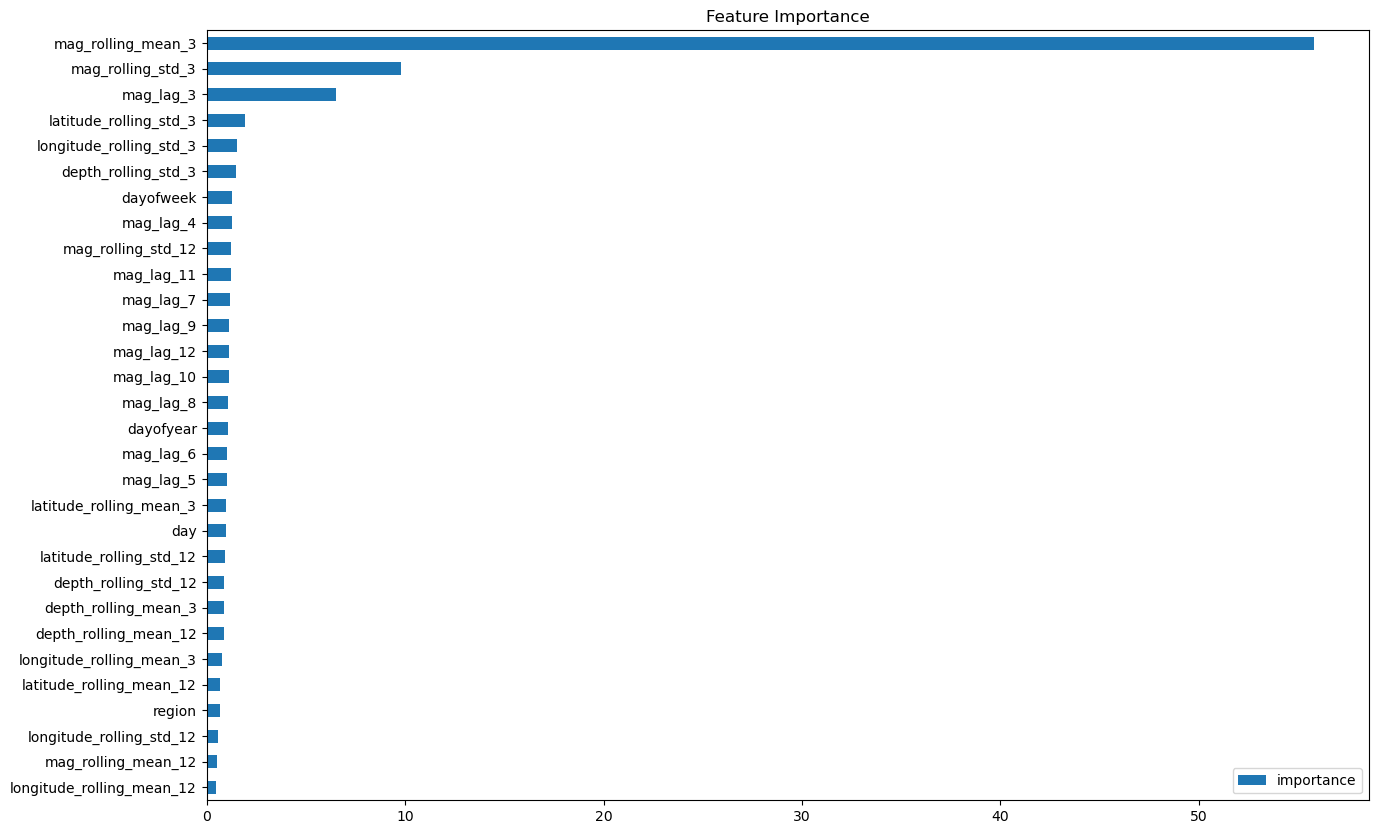

In [5]:
fi = pd.DataFrame(data=model.get_feature_importance(), index=model.feature_names_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(15, 10))
plt.show()